<a href="https://www.kaggle.com/code/jassermoreno/estimador-sueldos-nomina-estatal?scriptVersionId=114266623" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Analisis de Nomina Estatales Rep. Dominicana**

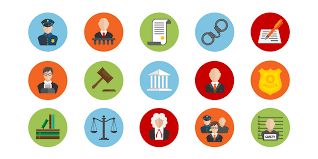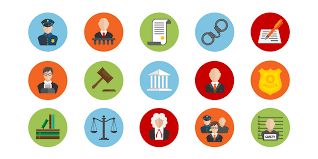

### Este Algoritmo recopila data de nomina estatal publica para consolidar un estimador de sueldos.

# Librerias

In [1]:
!pip install pyodbc
!pip install nltk
!pip install sweetviz

import os
from pathlib import Path
import csv
import random

import pandas as pd
import openpyxl
import numpy as np
#import webbrowser
import matplotlib.pyplot as plt

from datetime import datetime as dt
from pandas import Series
import re
import datetime
import time

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet as wn
from nltk import FreqDist
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import seaborn as sns

import math 
import sweetviz as sv
#####Para ignorar las advertencias
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.9/324.9 kB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 28.6 MB/s eta 0:00:0000:0100:01


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

In [2]:
%%time

df_1 = pd.read_excel("/kaggle/input/tbl-estimacion-ingreso-publicas-07/tbl_ESTIMACION_INGRESO_PUBLICAS.xlsx")
df_2 = pd.read_excel("/kaggle/input/tbl-estimacion-ingreso-publicas-08/tbl_ESTIMACION_INGRESO_PUBLICAS.xlsx")
df_3 = pd.read_excel("/kaggle/input/estimacion-ingreso-publicas-09/tbl_ESTIMACION_INGRESO_PUBLICAS.xlsx")
df_4 = pd.read_excel('/kaggle/input/estimacion-ingreso-publicas-10/tbl_ESTIMACION_INGRESO_PUBLICAS.xlsx')
df_5 = pd.read_excel("/kaggle/input/estimacion-ingreso-publicas-11/tbl_ESTIMACION_INGRESO_PUBLICAS.xlsx")
def_fun = pd.read_excel("/kaggle/input/def-fun/def_func.xlsx")


prov_rd = pd.read_excel('/kaggle/input/dominican-republic-provincias-coord/tbl_GEO_Provincias.xlsx')

prov_rd['Cod_Provincia'] = prov_rd['Cod_Provincia'].astype('str',errors ="ignore")
prov_rd['Cod_Provincia'].replace('1', '01', inplace=True)
prov_rd['Cod_Provincia'].replace('2', '02', inplace=True)
prov_rd['Cod_Provincia'].replace('3', '03', inplace=True)
prov_rd['Cod_Provincia'].replace('4', '04', inplace=True)
prov_rd['Cod_Provincia'].replace('5', '05', inplace=True)
prov_rd['Cod_Provincia'].replace('6', '06', inplace=True)
prov_rd['Cod_Provincia'].replace('7', '07', inplace=True)
prov_rd['Cod_Provincia'].replace('8', '08', inplace=True)
prov_rd['Cod_Provincia'].replace('9', '09', inplace=True)
prov_rd['Cod_Provincia'].replace('10', '10', inplace=True)

CPU times: user 8min 16s, sys: 798 ms, total: 8min 17s
Wall time: 8min 21s


# Consolidado de Nominas

In [3]:
%%time

fecha_hoy = datetime.datetime.now()

##,Procedemos,a,concatenar,todos,los,datasets,de,nomina,ya,realizados

   
df=pd.concat([
    
df_1,
df_2,
df_3,
df_4,
df_5,
    
       ],ignore_index=True)
    
#Limpieza del dataset
df.columns = df.columns.str.strip() #eliminar espacios blancos extras
   

CPU times: user 412 ms, sys: 55 ms, total: 467 ms
Wall time: 469 ms


In [4]:
def_fun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8087 entries, 0 to 8086
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FUNCION          8087 non-null   object
 1   fun_normalizada  8087 non-null   object
dtypes: object(2)
memory usage: 126.5+ KB


# ETL

### Se inicia el proceso de Extraccion, Transformacion y Carga, para depurar las variables a a utilizar y normalizar los campos de las columnas. Bajo este bloque:
* Se Clusterizan las Intituciones por tipo, para mejor manejo de los filtros.
* Se Normaliza los Tipos de Empleos, ejemplo: Fijo, Contrato, Pensionado a tipos uniformes.
* Se Agregan variables random para hacer featuring engienier (Edad, Rango Edad y Provincias).
* Se crea una funcion para agrupar las edades por rangos.
* Join a la tabla de Provincias para traer el nombre de las provincias de los Empleados.
* Join con la tabla func_def, la misma es un algoritmo desarrollado donde se extrae la raiz de de la funcion del empleado.

In [5]:
### Con la funcion fun_normalizada, podemos extraer la raiz de cada empleo. Y de esta forma poder obener promedio,
# mediana, desviacion estandar,por variables espeficias

gb_df = df.groupby(['FUNCION','fun_normalizada']).SUELDO_BRUTO.agg([len]).rename(columns={'len': 'Cant. Empleados'\
                                                                                                })

gb_df

KeyError: 'fun_normalizada'

In [ ]:
%%time

#////////////////////////////////////////CLASIFICACION DE INSTITUCION ////////////////////////////////////////////////

df.loc[df['INSTITUCION'] == 'ADMINISTRADORA DE RIESGOS DE SALUD PARA MAESTROS', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'ARMADA DE LA REPUBLICA DOMINICANA', 'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'AUTORIDAD PORTUARIA DOMINICANA', 'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'CDEE', 'CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'CENTRO DE OPERACIONES DE EMERGENCIAS (COE)'
                                                   , 'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE DISCAPACIDAD', 'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE DROGAS', 'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MICRO PEQUEÑA Y MEDIANA EMPRESA (PROMIPYME)',
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONANI','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CORPORACION DE ACUEDUCTO Y ALCANTARILLADO DE SANTO DOMINGO (CAASD)', 
                                                    'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CUERPO ESPECIALIZADO EN SEGURIDAD AEROPORTUARIA Y DE LA AVIACION CIVIL (CESAC)', 
                                                    'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'CUERPO ESPECIALIZADO PARA LA SEGURIDAD DEL METRO (CESMET)', 
                                                    'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DEFENSA CIVIL','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE BIENES NACIONALES'
                                                   , 'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE CONTRATACIONES PUBLICAS', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE EMBELLECIMIENTO DE CARRETERAS Y AVENIDAS DE CIRCUNVALACION (DIGECAC)', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE ETICA E INTEGRIDAD GUBERNAMENTAL (DIGEIG)', 
                                                    'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'DIRECCION GENERAL DE IMPUESTOS INTERNOS (DGII)', 
                                                    'CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'EDEESTE','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EDENORTE','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EDESUR','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'EJERCITO DE LA REPUBLICA DOMINICANA'
                                                   ,'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'INSTITUTO AGRARIO DOMINICANO (IAD)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DE DESARROLLO Y CREDITO COOPERATIVO (IDECOOP)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DE ESTABILIZACIÓN DE PRECIOS (INESPRE)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO DOMINICANO DE AVIACION CIVIL (IDAC)',
                                                   'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'INSTITUTO DOMINICANO DE TELECOMUNICACIONES (INDOTEL)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE AGUAS POTABLES Y ALCANTARILLADOS (INAPA)'
                                                   ,'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE ATENCION INTEGRAL A LA PRIMERA INFANCIA (INAIPI)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE BIENESTAR ESTUDIANTIL (INABIE)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE FORMACION TECNICO PROFESIONAL (INFOTEP)',
                                                       'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE PROTECCION DE LOS DERECHOS DEL CONSUMIDOR (PROCONSUMIDOR)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'INSTITUTO NACIONAL DE TRANSITO Y TRANSPORTE TERRESTRE (INTRANT)'
                                                   ,'CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'INSTITUTO TECNOLOGICO DE LAS AMERICAS (ITLA)',
                                                       'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'MINISTERIO ADMINISTRATIVO DE LA PRESIDENCIA (MAPRE)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE ADMINISTRACION PUBLICA (MAP)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE AGRICULTURA','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE CULTURA','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE DEFENSA (MIDE)','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE DEPORTES','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE ECONOMIA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION','CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION SUPERIOR CIENCIA Y TECNOLOGIA (MESCYT)'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE HACIENDA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE INDUSTRIA Y COMERCIO'
                                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE INTERIOR Y POLICIA','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE JUVENTUD','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE LA MUJER','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE LA VIVIENDA HABITAD Y EDIFICACIONES (MIVHED)',
                                                   'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE MINAS','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE SALUD','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE TRABAJO','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE TURISMO','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE ESTADISTICA (ONE)'
                                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE LA PROPIEDAD INDUSTRIAL (ONAPI)'
                                                    ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'OFICINA NACIONAL DE METEOROLOGIA (ONAMET)'
                                                   ,'CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'OFICINA PARA EL REORDENAMIENTO DEL TRANSPORTE (OPRET)',
                                                    'CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'OMSA','CLUSTER_INSTITUCION'] = 'TRANSPORTE'
df.loc[df['INSTITUCION'] == 'PROCURADURIA GENERAL DE LA REPUBLICA'
                                                   ,'CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'PROINDUSTRIA','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'PROMESECAL','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SERVICIO NACIONAL DE SALUD (SENASA)','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SERVICIO NACIONAL DE SALUD (SNS)','CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE BANCOS','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE ELECTRICIDAD','CLUSTER_INSTITUCION'] = 'ENERGIA'
df.loc[df['INSTITUCION'] == 'SUPERINTENDECIA DE PENSIONES (SIPEN)','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'SUPERINTENDENCIA DE SALUD Y RIESGOS LABORALES (SISALRIL)'
                                                   ,'CLUSTER_INSTITUCION'] = 'SALUD'
df.loc[df['INSTITUCION'] == 'SUPERINTENDENCIA DE SEGUROS','CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'TESORERIA NACIONAL','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'UNIVERSIDAD AUTONOMA DE SANTO DOMINGO (UASD)'
                                                   ,'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'ZOOLOGICO NACIONAL','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'CONTRALORIA','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'DIRECCION NACIONAL DE MIGRACION','CLUSTER_INSTITUCION'] = 'CASTRENSE'
df.loc[df['INSTITUCION'] == 'DIRECCION NACIONAL DE PRESUSPUESTO','CLUSTER_INSTITUCION'] = 'FINANZAS'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE MEDIO AMBIENTE','CLUSTER_INSTITUCION'] = 'MEDIO AMBIENTE'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE RELACIONES EXTERIORES'
                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'MINISTERIO DE EDUCACION SUPERIOR CIENCIA Y TECNOLOGIA (MESCYT)'
                                       ,'CLUSTER_INSTITUCION'] = 'EDUCACION'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL DE PROMOCION Y APOYO A LA MICRO PEQUEÑA Y MEDIANA EMPRESA (PROMIPYME)'
                                        ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONSJEO NACIONAL PARA EL VIH Y EL SIDA (CONAVIHSIDA)'
                                       ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'
df.loc[df['INSTITUCION'] == 'CONSEJO NACIONAL PARA LA NIÑEZ Y LA ADOLESCENCIA (CONANI)'
                                   ,'CLUSTER_INSTITUCION'] = 'ADMINISTRATIVO'

#//////////////////////////////////////////////////////////////////////////////////////////

## Carrera Adm.
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['DE CARRERA', 'EMPLEADA DE CARRERA ADMINISTRATIVA', 'EMPLEADA DE CARRERA ADMINISTRATIVA','EMPLEADO DE CARRERA ADMINISTRATIVA','CARRERA ADM.',
                '2. CARRERA','CARRERA','CARRERA DAM.','EMPLEADO DE CARRERA'], 
    value='CARRERA ADMINISTRATIVA')

## Cargo de Confianza.
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['EMP DE CONFIANZA','DE CONFIANZA','CARGOS DE CONFIANZA','CONFIANZA','D/CONFIANZA','EMPLEADO DE CONFIANZA','PERSONAL DE CONFIANZA'], 
    value='CARGO DE CONFIANZA')

## Designado
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['DESIGNADO/CARRERA ADMINISTRATIVA','DESIGNADO DEC NUM 176-21','DESIGNADAS','DESIGNADA','DESIGANDO'], 
    value='DESIGNADO')

## Estatuto Simplificado
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['SIMPLIFICADOS','ESTATUTO SIMP','ESTATUTO SIMPLIFICADO','ESTATUTO SIMP',
                'ESTATUTOS SIMPLIFICADOS','STATUTO SIMPLIFICADO', 'STATUTO SIMPLIFICADO]','3. ESTATUTO SIMPLIFICADO','STATUTO SIMPLIFIADO'], 
    value='ESTATUS SIMPLIFICADO')

## Fijo
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['FIJOS','FIJOII','FIJO II','EMP FIJO','*FIJO','EMPLEADA FIJA (POR DECRETO)', 'EMPLEADA FIJA','EMPLEADO FIJO (POR DECRETO)','EMPLEADO FIJO','PERSONAL FIJO'], 
    value='FIJO')

## Libre Nombramiento
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['LIBRE NOMBRAMIENTO Y REMOCIÓN','LIBRE NOM Y REMOCIÓN','1. LIBRE NOMBRAMIENTO Y REM.','DE LIBRE NOMBRAMIENTO Y REMOCION','LIBRE  NOMBRAMIENTO Y REMOCIÓN','DE LIBRE NOMBRAMIENTO Y REMOCIÓN',
               'LIBRE  NOMBRAMIENTO Y REMOCIÓN','LIBRE NOMBRAMIENTO \nY REMOCION','LIBRE NOMBRAMIENTO','LIBRE NOMBRAMIENTO Y REMOCION'], 
    value='LIBRE NOMBRAMIENTO Y REMOCION')

## Probatorio
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['PERIODO PROBATORIO INGRESO CAR','P.PRUEBA','PERIODO PROBATORIO INGRESO CARRERA','4. TEMPORALES','TEMPORAL','EMPLEADOS TEMPORALES'], 
    value='PROBATORIO')

## Pensionados
df['TIPO_EMPLEADO'] = df['TIPO_EMPLEADO'].replace(
    to_replace=['PRE PENSION','TRAMITE DE PENSION','TRAMITE DE PENSIÓN','TRÁMITE DE PENSIÓN'], 
    value='PENSIONADO')


# ///////////////////////////////////////////////////////////////////////////////////////
df.loc[df['TIPO_EMPLEADO'] == 'FIJO', 'TIPO_EMPLEADO'] = 'FIJO'
df.loc[df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA', 'TIPO_EMPLEADO'] = 'CARRERA ADMINISTRATIVA'
df.loc[df['TIPO_EMPLEADO'] == 'CONTRATADO', 'TIPO_EMPLEADO'] = 'CONTRATADO'
df.loc[df['TIPO_EMPLEADO'] == 'ESTATUTO SIMPLIFICADO', 'TIPO_EMPLEADO'] = 'ESTATUTO SIMPLIFICADO'
df.loc[df['TIPO_EMPLEADO'] == 'DESIGNADO', 'TIPO_EMPLEADO'] = 'DESIGNADO'
df.loc[df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA', 'TIPO_EMPLEADO'] = 'CARGO DE CONFIANZA'
df.loc[df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION', 'TIPO_EMPLEADO'] = 'LIBRE NOMBRAMIENTO Y REMOCION'
df.loc[df['TIPO_EMPLEADO'] == 'PROBATORIO', 'TIPO_EMPLEADO'] = 'PROBATORIO'
df.loc[df['TIPO_EMPLEADO'] == 'PENSIONADO', 'TIPO_EMPLEADO'] = 'PENSIONADO'

df.loc[(df['TIPO_EMPLEADO'] != 'FIJO') 
                   & (df['TIPO_EMPLEADO'] != 'CARRERA ADMINISTRATIVA')
                   & (df['TIPO_EMPLEADO'] != 'CONTRATADO')
                   & (df['TIPO_EMPLEADO'] != 'ESTATUTO SIMPLIFICADO')
                   & (df['TIPO_EMPLEADO'] != 'DESIGNADO')
                   & (df['TIPO_EMPLEADO'] != 'CARGO DE CONFIANZA')
                   & (df['TIPO_EMPLEADO'] != 'LIBRE NOMBRAMIENTO Y REMOCION')
                   & (df['TIPO_EMPLEADO'] != 'PROBATORIO')
                   & (df['TIPO_EMPLEADO'] != 'PENSIONADO')
                   , 'TIPO_EMPLEADO'] = 'OTROS'

#//////////////////////////////////////////////////////////////////////////////////////////////////////////////
def_fun['fun_normalizada'].replace("", 'Otros', inplace=True)

df_11 = pd.merge(df,def_fun,how='left',left_on='FUNCION',
                        right_on='FUNCION')


df = df_11

#///////////////////////////////////////////////////////////////////////////////////////////////////////

df['COD_PROVINCIA'] = np.random.randint(1,32,size=(len(df),1))
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].round()
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].astype('str',errors ="ignore")
df['COD_PROVINCIA'] = df['COD_PROVINCIA'].str.zfill(2)

df_12 = pd.merge(df_11,prov_rd[['Provincia','Cod_Provincia']],how='left',left_on='COD_PROVINCIA',
                        right_on='Cod_Provincia')


df = df_12


#/////////////////////////////////////////////////////////////////////////

df['EDAD'] = np.random.randint(18,70,size=(len(df),1))
df['EDAD'] = df['EDAD'].round()
df['EDAD'] = df['EDAD'].astype('int',errors ="ignore")

#/////////////////////////////////////////////////////////////////////////////

def rango_edad(df):

     if (df['EDAD']<=18):
        return  "Rango Edad de 0 a 18 Años"
     if (df['EDAD']<25):
        return  "Rango Edad de 19-25"
     if (df['EDAD']<35):
        return  "Rango Edad de 26-35"
     if (df['EDAD']<45):
        return  "Rango Edad de 36-45"
     if (df['EDAD']<55):
        return  "Rango Edad de 46-55"
     if (df['EDAD']<65):
        return  "Rango Edad de 56-65"
     if (df['EDAD']<75):
        return  "Rango Edad de 66-75"
     if (df['EDAD']<85):
        return  "Rango Edad de 76-85"
     if (df['EDAD']<95):
        return  "Rango Edad de 86-95"
     else:
        return 'Otro'

df['Rango_Edad'] = df.apply(rango_edad, axis = 1)


# Analisis Decriptivo de Sueldos
### Nuestra variable target son SUELDO BRUTO y SUELDO NETO, las cuales nos ayudaran en el analisis de los Sueldos en todos los niveles. En esta variable SUELDO BRUTO, tenemos muchos datos atipicos (outliers) que desenfocan los sueldos, esto mas adelante lo estaremos normalizando en base a funciones.

In [ ]:
gb_TIPO_EMPLEADO = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio'})
gb_TIPO_EMPLEADO.head(10).sort_values(by='Sueldo Promedio', ascending=False )



In [ ]:
### En este grafico de Correlacion podemos ver los sueldos agrupados por Tipo de Empleado. Viendo mas de cerca los datos atipicos.

var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=45);

# Analisis Descriptivo y Exploratorio (EDA)

In [ ]:
## Con la Libreria de SweetViz realizamos un analisis descriptivo y de correlacion de nuestro Dataframe.

%%time
my_report = sv.analyze(df)
my_report.show_html('Report.html')
my_report.show_notebook()

In [ ]:
var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_NETO'].max()
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_NETO", data=data)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=90);

In [ ]:
var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=300000);
plt.xticks(rotation=90);

# Normalizacion de la Variable Sueldo Bruto

### Con estas funciones estaremos detectando los outliers y reemplazandolo por los valores de la mediana, siendo el caso esten por encima de los valores tipicos. Esto, agrupandolos por la variable Tipo de Empleado.

In [ ]:
def asig_mean_sueldo (df):
    
    if df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA':
        return 89656.80
    elif df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA':
        return 62887.25
    elif df['TIPO_EMPLEADO'] == 'CONTRATADO':
        return 49146.97
    elif df['TIPO_EMPLEADO'] == 'DESIGNADO':
        return 25165.50
    elif df['TIPO_EMPLEADO'] == 'FIJO':
        return 35337.49
    elif df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION':
        return 89621.34
    elif df['TIPO_EMPLEADO'] == 'OTROS':
        return 34950.49
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 18057.73
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 42732.24
    else:
        return 0.0
    
df['validacion_prom_sueldo'] = df.apply(asig_mean_sueldo, axis = 1)

def asig_std_sueldo (df):
    
    if df['TIPO_EMPLEADO'] == 'CARGO DE CONFIANZA':
        return 52153.691242
    elif df['TIPO_EMPLEADO'] == 'CARRERA ADMINISTRATIVA':
        return 46295.284673
    elif df['TIPO_EMPLEADO'] == 'CONTRATADO':
        return 20271.566289
    elif df['TIPO_EMPLEADO'] == 'DESIGNADO':
        return 32647.894459
    elif df['TIPO_EMPLEADO'] == 'FIJO':
        return 25293.993622
    elif df['TIPO_EMPLEADO'] == 'LIBRE NOMBRAMIENTO Y REMOCION':
        return 88471.470558
    elif df['TIPO_EMPLEADO'] == 'OTROS':
        return 37001.931032
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 19058.436992
    elif df['TIPO_EMPLEADO'] == 'PENSIONADO':
        return 18005.772377
    else:
        return 0.0
df['validacion_std_sueldo'] = df.apply(asig_std_sueldo, axis = 1)


gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([np.mean])\
.rename(columns={'mean': 'Sueldo'})


gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([np.std])\
.rename(columns={'std': 'Sueldo'})

df['outliers'] = (df['SUELDO_BRUTO']-df['validacion_prom_sueldo']).abs() > 2*df['validacion_std_sueldo']

def reempl_outliers (df):
    if df['outliers'] == True:
        return df['validacion_prom_sueldo']
    else:
        return df['SUELDO_BRUTO']
    
df['SUELDO_BRUTO'] = df.apply(reempl_outliers, axis = 1)


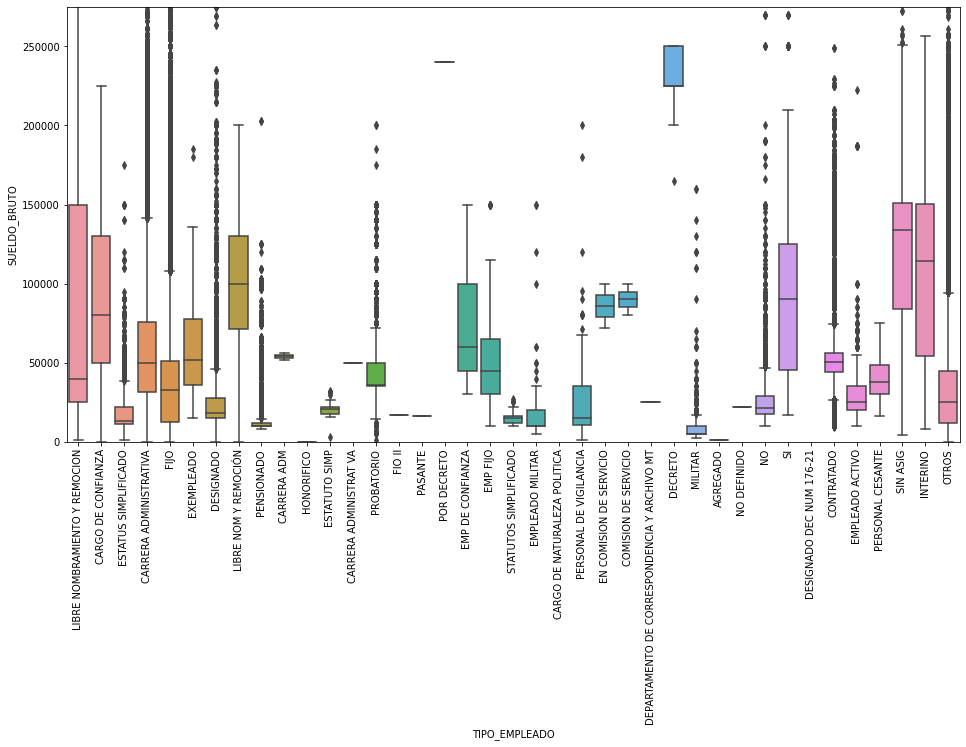

In [7]:
#Aqui vemos los valores ya normalizados sin los datos atipicos por encima de la mediana. Ya aplicadas las funciones.
var = 'TIPO_EMPLEADO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=275000);
plt.xticks(rotation=90);

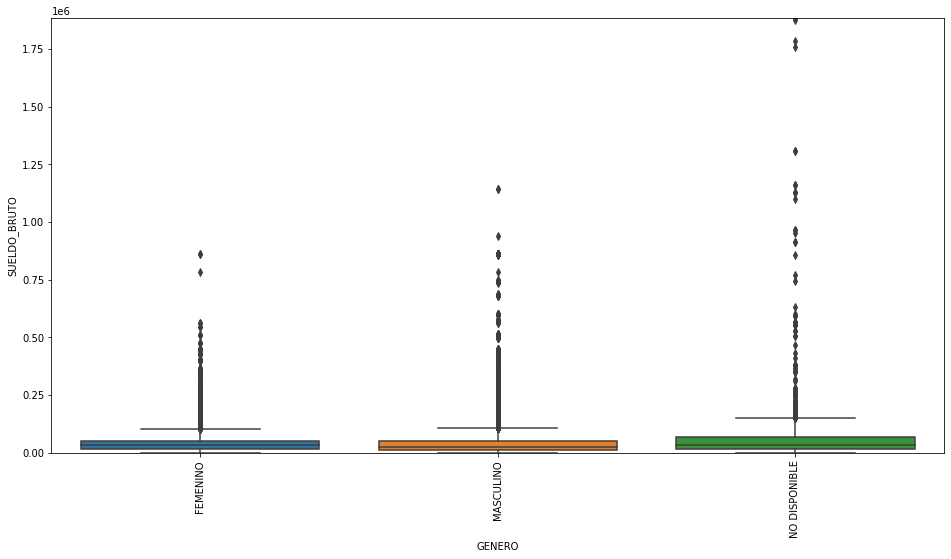

In [6]:
var = 'GENERO'
max_s = df['SUELDO_BRUTO'].max()
data = pd.concat([df['SUELDO_BRUTO'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SUELDO_BRUTO", data=data)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=90);

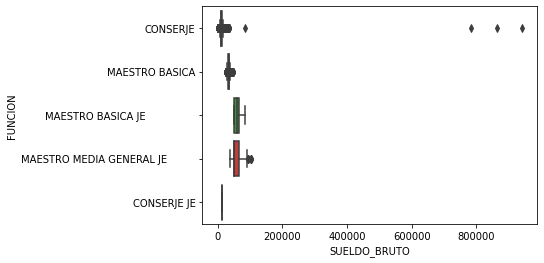

In [8]:
top_cargo = (
    df["FUNCION"].value_counts().sort_values(ascending=False).head(5).index.values
)
sns.boxplot(
    y="FUNCION",
    x="SUELDO_BRUTO",
    data=df[df["FUNCION"].isin(top_cargo)],
    orient="h",
);

In [ ]:
med_1 = "AREA"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [ ]:
med_1 = "fun_normalizada"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [ ]:
med_1 = "CLUSTER_INSTITUCION"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [ ]:
gb_df = df.groupby(['TIPO_EMPLEADO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(10).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_df = df.groupby(['INSTITUCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(10).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_df = df.groupby(['FUNCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(10).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada','FUNCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada','GENERO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )
gb_df

In [ ]:
gb_institucion = df.groupby(['GENERO']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio'})

gb_institucion.head(10).sort_values(by='Sueldo Promedio', ascending=False )

In [ ]:
platform_genero_sueldo = (
    df.pivot_table(
        index="TIPO_EMPLEADO", columns="GENERO", values="SUELDO_BRUTO", aggfunc=sum
    )
    .fillna(0)
    .applymap(float)
)
sns.heatmap(platform_genero_sueldo, annot=True, fmt=".1f", linewidths=0.5);

In [ ]:
med_1 = "INSTITUCION"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)

platform_genero_sueldo = (
    df.pivot_table(
        index='CLUSTER_INSTITUCION', columns="GENERO", values="SUELDO_BRUTO", aggfunc=sum
    )
    .fillna(0)
    .applymap(float)
)
sns.heatmap(platform_genero_sueldo, annot=True, fmt=".1f", linewidths=0.5);

In [ ]:
var = 'SUELDO_BRUTO'
data = pd.concat([df['SUELDO_NETO'], df[var]], axis=1)
data.plot.scatter(x=var, y='SUELDO_NETO', ylim=(0,900000));

# Analisis Demografico

### En el analisis aqui tenemos el exportable Promedio de Sueldos, por Funcion, y por Provincia, aportandonos el valor de cual es el sueldo promedio por variables como:
* GENERO, 
* PROVINCIA, 
* RANGO DE EDAD Y 
* FUNCION

In [ ]:
gb_df = df.groupby(['fun_normalizada','Provincia']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )

gb_df.to_excel('gb_df_funcion-provincia.xlsx', index=True)

gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada','Rango_Edad']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )

gb_df.to_excel('gb_df_funcion-rango_edad.xlsx', index=True)
gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada','GENERO','Rango_Edad']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)

gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.head(50).sort_values(by='Sueldo Promedio', ascending=False )

gb_df.to_excel('gb_df_funcion-rango_edad-genero.xlsx', index=True)
gb_df

In [ ]:
gb_df = df.groupby(['fun_normalizada','FUNCION']).SUELDO_BRUTO.agg([len, np.min,\
                                                               np.max,np.mean,np.std]).rename(columns={'len': 'Cant. Empleados',\
                                                                                                'amin': 'Sueldo Minimo',\
                                                                                               'amax': 'Sueldo Maximo',\
                                                                                               'mean': 'Sueldo Promedio',\
                                                                                                'std': 'Desviacion Estandar'})

gb_df['Sueldo Promedio'] = gb_df['Sueldo Promedio'].round()

gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].round()
gb_df['Sueldo Maximo'] = gb_df['Sueldo Maximo'].apply('{:,}'.format)

gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].round()
gb_df['Sueldo Minimo'] = gb_df['Sueldo Minimo'].apply('{:,}'.format)

gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].round()
gb_df['Desviacion Estandar'] = gb_df['Desviacion Estandar'].apply('{:,}'.format)


gb_df.sort_values(by='Cant. Empleados', ascending=False )
gb_df['Cant. Empleados'] = gb_df['Cant. Empleados'].apply('{:,}'.format)

gb_df.sort_values(by='Cant. Empleados', ascending=False )
gb_df.to_excel('gb_df_funcion-normalizada.xlsx', index=True)
gb_df

In [ ]:
med_1 = "Rango_Edad"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [ ]:
med_1 = "Provincia"
med_2 = "SUELDO_BRUTO"
top = (
    df[med_1].value_counts().sort_values(ascending=False).head(10).index.values
)
sns.boxplot(
    y=med_1,
    x=med_2,
    data=df[df[med_1].isin(top)],
    orient="h",
);

In [ ]:
df